In [1]:
import numpy as np
import json
import os
import random
import matplotlib.pyplot as plt

## Loading data to use as reference (annotazioni fatte a mano da Andrea)

In [2]:
annotations_qa_root = '/media/data7/DATASET/shapenerf_objanerf_text/spatial_gpt4point_qa/texts'
with open(os.path.join(annotations_qa_root, 'spatial_gpt4point_qa_no_vec.json'), 'r') as f:
    annotations_qa = json.load(f)
print(len(annotations_qa))
print(annotations_qa[0])  

annotations_cap_root = '/media/data7/DATASET/shapenerf_objanerf_text/spatial_gpt4point_cap/texts'
with open(os.path.join(annotations_cap_root, 'spatial_gpt4point_cap.json'), 'r') as f:
    annotations_cap = json.load(f)
print(len(annotations_cap))
print(annotations_cap[0])

data_root = '/media/data7/DATASET/objanerf_text_evaluation_data/imgs_from_objaverse/gpt4point_test'

190
{'object_id': '44795759d6144f61990796c02088665f', 'conversations': [{'from': 'human', 'value': 'What is the rabbit wearing around its neck?\nA: A red necklace\nB: A red tie\nC: A red scarf'}, {'from': 'gpt', 'value': 'C: A red scarf'}]}
100
{'object_id': '1915ece903a5406d8b59b3af3954b943', 'conversations': [{'from': 'human', 'value': '<point>\nProvide a very detailed description of the object knowing that its caption is: "A low-polygon, golden trophy with a small handle base.". Focus on the relative positions of the parts of the object. Include as many details as possible. Do not hallucinate. Focus only on the content of the images. Focus only on the foreground.'}, {'from': 'gpt', 'value': "The trophy is a three-dimensional object with a smooth, golden surface. It has a cylindrical body with a slightly flared top and a very thin circular base. The trophy has two handles: one on each side. The trophy's design is simplistic, with no visible textures or patterns, giving it a uniform a

In [3]:
object_ids = [annotation['object_id'] for annotation in annotations_qa]
object_ids = list(set(object_ids))
print(len(object_ids))

random_id = random.choice(object_ids)
print(random_id)

98
530754c90ee44f06a5b10d233ec4705f


530754c90ee44f06a5b10d233ec4705f
Q 1: Which accessory is the skull wearing?
A: A straw hat
B: A velvet hat
C: A cap
====  A: A straw hat  ==== 


Question: <point>
Provide a very detailed description of the object knowing that its caption is: A skull wearing a straw hat, with two crossed bones in front.. Focus on the relative positions of the parts of the object. Include as many details as possible. Do not hallucinate. Focus only on the content of the images. Focus only on the foreground.
GT:  The object is a three-dimensional representation of a skull wearing a straw hat. The skull has a broad, flat hat with a textured surface, resembling a straw hat. The two crossed bones in front of the skull are positioned in a crisscross fashion, with the tips of the bones pointing upwards. The skull itself has a smooth, rounded face with two eye sockets, a nose cavity, and a mouth.


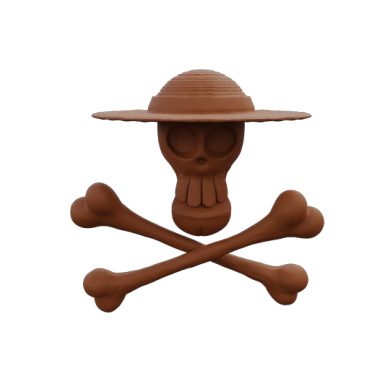

In [4]:
qa = [annotation for annotation in annotations_qa if annotation['object_id'] == random_id]
cap = [annotation for annotation in annotations_cap if annotation['object_id'] == random_id]
#print('QA annotations:', qa[0]['conversations'][0]['value'])
print(random_id)
for i, q in enumerate(qa):
    print(f'Q {i+1}: {q["conversations"][0]["value"]}')
    print('==== ', q['conversations'][1]['value'], ' ==== ')
    print('\n')

print('Question:', cap[0]['conversations'][0]['value'])
print('GT: ', cap[0]['conversations'][1]['value'])
image_path = os.path.join(data_root, random_id, '018.png')
plt.imshow(plt.imread(image_path))
plt.axis('off')
plt.show()

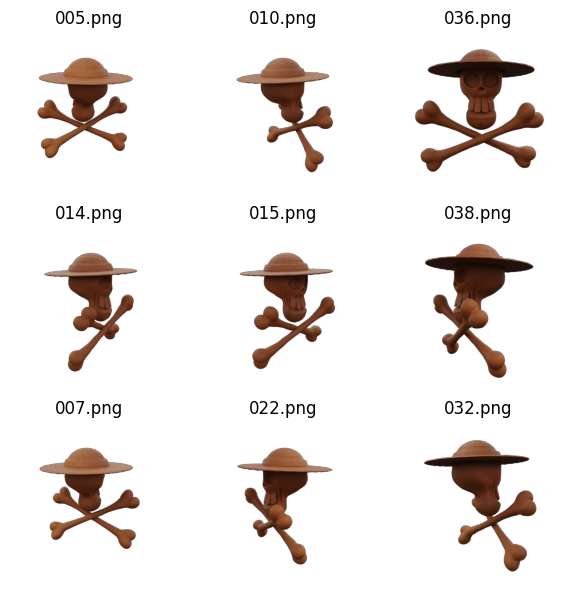

In [5]:
# visualize a grid with all the images of the object
def visualize_object_images(object_id, data_root, num_images=9):
    object_path = os.path.join(data_root, object_id)
    image_files = [f for f in os.listdir(object_path) if f.endswith('.png')]
    random.shuffle(image_files)
    image_files = image_files[:num_images]

    fig, axs = plt.subplots(3, 3, figsize=(6, 6))
    axs = axs.flatten()

    for ax, img_file in zip(axs, image_files):
        img_path = os.path.join(object_path, img_file)
        ax.imshow(plt.imread(img_path))
        ax.axis('off')
        ax.set_title(img_file)

    plt.tight_layout()
    plt.show()

visualize_object_images(random_id, data_root, num_images=9)

# Run VLM on input images

In [6]:
# pip install accelerate
from transformers import AutoProcessor, Gemma3ForConditionalGeneration, BitsAndBytesConfig
from transformers import pipeline
import torch

from PIL import Image

/home/mgaliazzo/.pyenv/versions/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
os.system('export CUDA_HOME=/usr/local/cuda-12.4')
os.system('export PATH=$CUDA_HOME/bin:$PATH')
os.system('export LD_LIBRARY_PATH=$CUDA_HOME/lib64:$LD_LIBRARY_PATH')

0

In [8]:
model_id = "google/gemma-3-12b-it"

# bnb_config = BitsAndBytesConfig(
#     load_in_4bit=True,
#     bnb_4bit_quant_type="nf4",
#     bnb_4bit_compute_dtype=torch.bfloat16,
#     bnb_4bit_use_double_quant=True,
# )

bnb_config = BitsAndBytesConfig(
    load_in_8bit=True,
)

device = 'cuda:2'
model = Gemma3ForConditionalGeneration.from_pretrained(
    model_id, low_cpu_mem_usage=True, quantization_config=bnb_config, device_map=device
).eval()

processor = AutoProcessor.from_pretrained(model_id)


Loading checkpoint shards: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [ ]:
image_names = ['000.png', '010.png', '015.png', '020.png']
data_root = "media7link/gpt4point_test/"
random_id = "ba341c4ce89647ea9f6996ec58e3eacf"

images_paths = [os.path.join(data_root, random_id, img_name) for img_name in image_names]
images = [Image.open(p) for p in images_paths]

# images = [os.path.join(data_root, random_id, img_name) for img_name in image_names]

messages = [
    {
        "role": "system",
        "content": [{"type": "text", "text": "You are a helpful assistant."}]
    },
    {
        "role": "user",
        "content": [
            {"type": "image", "image": images[0]},
            {"type": "text", "text": "Please describe the object in the image."}
        ]
    }
]

inputs = processor.apply_chat_template(
    messages, add_generation_prompt=True, tokenize=True,
    return_dict=True, return_tensors="pt"
).to(model.device, dtype=torch.bfloat16)

input_len = inputs["input_ids"].shape[-1]

with torch.inference_mode():
    generation = model.generate(**inputs, max_new_tokens=100, do_sample=False)

print("\n--- Full Decoded Output (including prompt and special tokens) ---")
# Use skip_special_tokens=False to see EVERYTHING
full_decoded = processor.decode(generation[0], skip_special_tokens=False)
print(full_decoded)
print("-"*40)

# **Overall Impression:** The image is a close-up shot of a vibrant garden scene, 
# focusing on a cluster of pink cosmos flowers and a busy bumblebee. 
# It has a slightly soft, natural feel, likely captured in daylight.

The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



--- Full Decoded Output (including prompt and special tokens) ---
<bos><start_of_turn>user
You are a helpful assistant.



<start_of_image><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_to